# Calculating and plotting VOD

In [1]:
import gnssvod as gv
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.dates as mdates

## gv.calc_vod()
The first step is to calculate VOD for different bands.

Note that this function will likely be modified in a next release. One problem is that the observations labels ('S1C','S1X', etc.) are not always associated to the same frequency depending on which constellation is observed. The labeling also changes according to the RINEX versions. In the future, frequency will need to be tracked along with SNR.

In [9]:
# set which data files should be loaded
pattern = 'data_pr/MACROCOSM_paired/*.nc'
# define how to associate stations together. Always put reference station first.
pairings = {'MACROCOSM':('MACROCOSM-5','MACROCOSM-1')}
# define if some observables with similar frequencies should be combined together. In the future, this should be replaced by the selection of frequency bands.
bands = {'VOD1':['S1','S1X','S1C'],'VOD2':['S2','S2X','S2C']}

vod = gv.calc_vod(pattern,pairings,bands)
vod = vod['MACROCOSM']
vod

VOD1      VOD2  Azimuth  Elevation
Epoch               SV                                         
2023-09-25 13:32:15 C20       NaN       NaN   -104.4       34.6
                    C27       NaN       NaN    136.2       70.6
                    C30       NaN       NaN    -37.3       53.6
                    C32       NaN       NaN    -19.4       59.6
                    E04       NaN       NaN   -150.7       84.1
...                           ...       ...      ...        ...
2023-09-25 14:18:30 R02 -0.027389       NaN   -116.8       17.3
                    R08 -0.617071 -0.822761     11.9       31.7
                    R22  1.252631  1.508545    143.8       35.8
                    R23       NaN       NaN      NaN        NaN
                    R24 -0.183166 -0.355558    -24.5       27.9

[4702 rows x 4 columns]

## Hemispheric plot of VOD
Same as in the previous example, we will use the Hemi class to calculate and plot a gridded representation of VOD

In [10]:
# intialize hemispheric grid
hemi = gv.hemibuild(2)
# get patches for plotting later
patches = hemi.patches()
# classify vod into grid cells, drop azimuth and elevation afterwards as we don't need it anymore
vod = hemi.add_CellID(vod).drop(columns=['Azimuth','Elevation'])
# get average value per grid cell
vod_avg = vod.groupby(['CellID']).agg(['mean', 'std', 'count'])
# flatten the columns
vod_avg.columns = ["_".join(x) for x in vod_avg.columns.to_flat_index()]
vod_avg

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gnssvod/hemistats.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  idf=idf.groupby('eleind',group_keys=False).apply(azicut) # groupby will drop rows with eleind=NaN
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gnssvod/hemistats.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  iele = idf.eleind[0]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gnssvod/hemistats.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versio

,VOD1_mean,VOD1_std,VOD1_count,VOD2_mean,VOD2_std,VOD2_count
CellID,,,,,,
6,NaN,NaN,0,NaN,NaN,0
7,NaN,NaN,0,NaN,NaN,0
18,NaN,NaN,0,NaN,NaN,0
19,NaN,NaN,0,NaN,NaN,0
22,NaN,NaN,0,NaN,NaN,0
...,...,...,...,...,...,...
6195,NaN,NaN,0,NaN,NaN,0
6239,-0.051529,0.083922,5,NaN,NaN,0
6240,0.034295,0.006962,2,0.016877,NaN,1


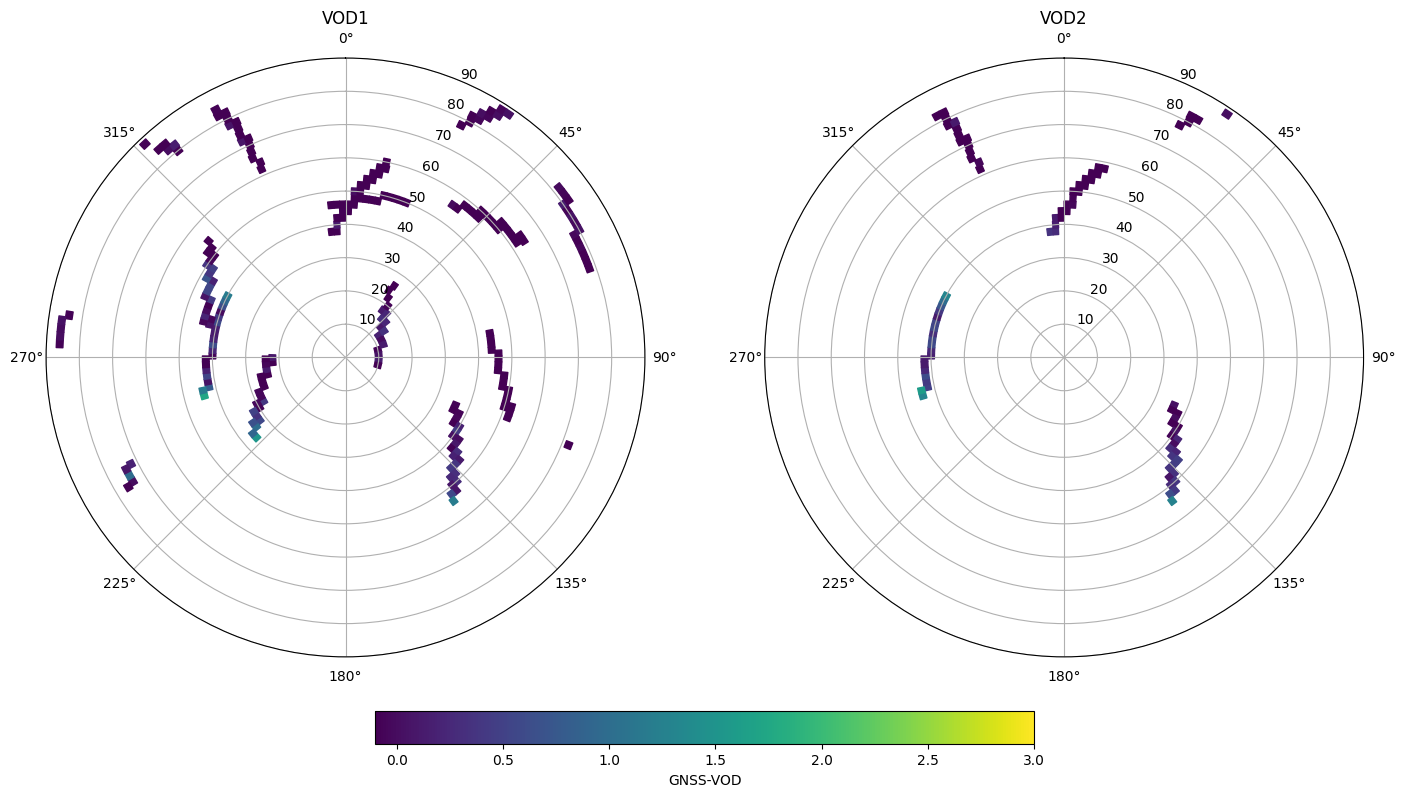

In [11]:
fig, ax = plt.subplots(1,2,figsize=(17,14),subplot_kw=dict(projection='polar'))

vod_names = ['VOD1','VOD2']
for i, iname in enumerate(vod_names):
    # associate the mean values to the patches, join inner will drop patches with no data, making plotting slightly faster
    ipatches = pd.concat([patches,vod_avg[f"{iname}_mean"]],join='inner',axis=1)
    # plotting with colored patches
    pc = PatchCollection(ipatches.Patches,array=ipatches[f"{iname}_mean"],edgecolor='face', linewidth=1)
    pc.set_clim([-0.1,3])
    ax[i].add_collection(pc)
    ax[i].set_rlim([0,90])
    ax[i].set_theta_zero_location("N")
    ax[i].set_theta_direction(-1)
    ax[i].set_title(iname)

plt.colorbar(pc, ax=ax, location='bottom', shrink=.5, pad=0.05, label='GNSS-VOD')

It can be a good idea to only plot the average if a minimum number of values were used to calculate an average. Sometimes results at the edges are only based on a few data points and are not very reliable.

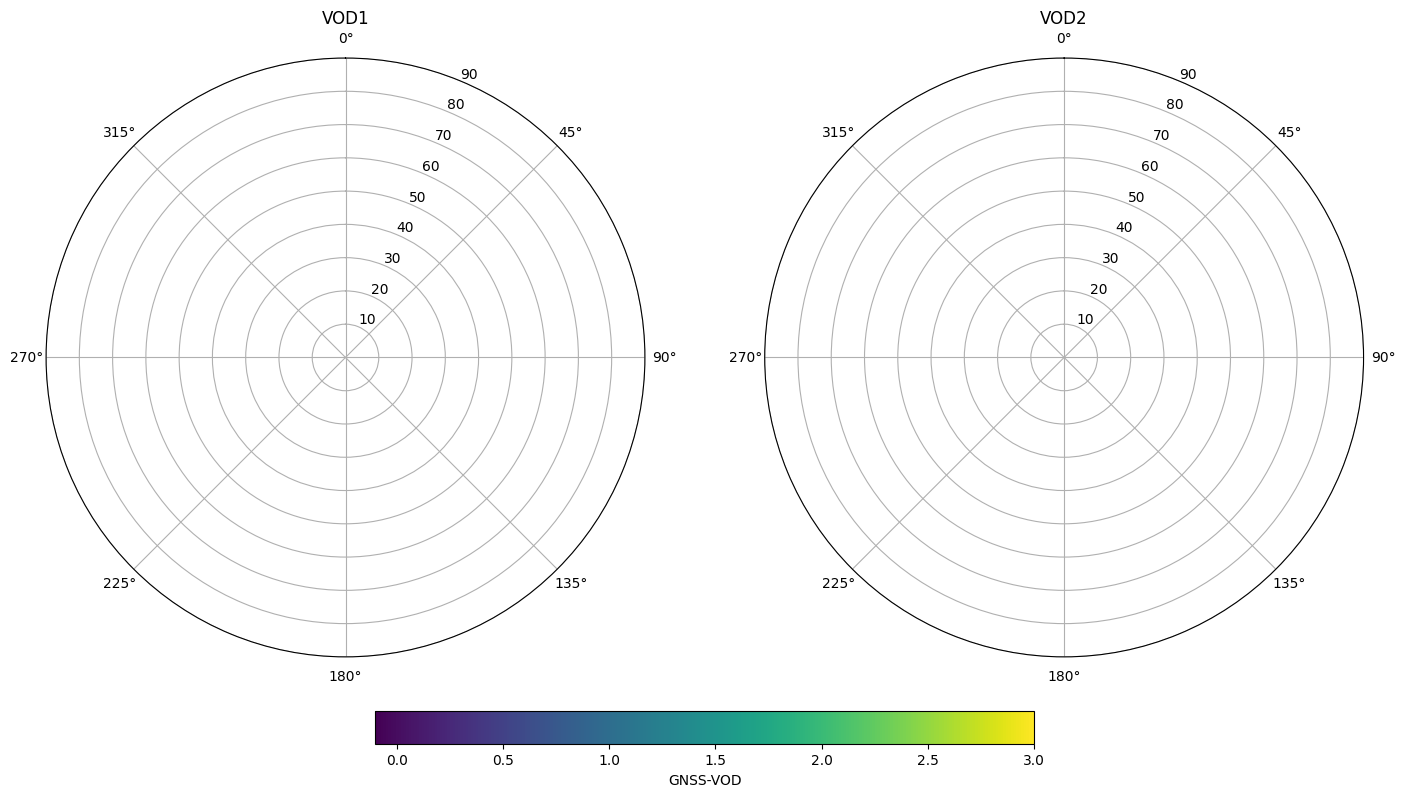

In [12]:
fig, ax = plt.subplots(1,2,figsize=(17,14),subplot_kw=dict(projection='polar'))

vod_names = ['VOD1','VOD2']
for i, iname in enumerate(vod_names):
    # associate the mean values to the patches, join inner will drop patches with no data, making plotting slightly faster
    ivod_data = vod_avg[f"{iname}_mean"].where(vod_avg[f"{iname}_count"]>40)
    ipatches = pd.concat([patches,ivod_data],join='inner',axis=1)
    # plotting with colored patches
    pc = PatchCollection(ipatches.Patches,array=ipatches[f"{iname}_mean"],edgecolor='face', linewidth=1)
    pc.set_clim([-0.1,3])
    ax[i].add_collection(pc)
    ax[i].set_rlim([0,90])
    ax[i].set_theta_zero_location("N")
    ax[i].set_theta_direction(-1)
    ax[i].set_title(iname)

plt.colorbar(pc, ax=ax, location='bottom', shrink=.5, pad=0.05, label='GNSS-VOD')

## Calculation of VOD time series
Because the tracks of the satellites are not random but tend to repeat every day, one has to be a bit careful when computing temporal averages of VOD. For instance, satellites of the GPS constellation repeat twice every sidereal day (1 sidereal day = 23h 56m 4s). Other constellations (below) have slightly more complex repeat times.

![](figures/rev_per_day.png)

Imagine what would happen if most GNSS satellites happen to repeatedly go over slightly denser areas of the canopy every day at around 3:30pm. We would tend to see a peak in VOD each day at that time. However, the average VOD of the forest is not actually increasing, the peak exists only because we happen to be measuring parts of the canopy that are on average slightly denser. Especially when looking at very small changes in VOD (for instance diurnal variability), these repeating orbits create spurious signals and obfuscate the real variability. Check __[Humphrey & Frankenberg 2023](https://bg.copernicus.org/articles/20/1789/2023/bg-20-1789-2023.html)__, Figure 7 to see how this affects time series. 

Processing a more accurate VOD time series involves three steps:
- Calculating a baseline (long-term mean) hemispheric VOD over a sufficiently long time period (which we just did)
- Calculate VOD anomalies by subtracting the baseline from each instantaneous VOD measurement
- Calculate a time series based on the VOD anomalies

### Calculating VOD anomalies
Here we merge back the VOD average to the original dataframe.

In [13]:
# merge statistics with the original VOD measurements
vod_anom = vod.join(vod_avg,on='CellID')
vod_anom

VOD1      VOD2  CellID  VOD1_mean  VOD1_std  \
Epoch               SV                                                     
2023-09-25 13:32:15 C20       NaN       NaN    2933        NaN       NaN   
                    C27       NaN       NaN     387        NaN       NaN   
                    C30       NaN       NaN    1308        NaN       NaN   
                    C32       NaN       NaN     931        NaN       NaN   
                    E04       NaN       NaN      38        NaN       NaN   
...                           ...       ...     ...        ...       ...   
2023-09-25 14:18:30 R01  0.836662  1.307284    1584   1.195154  0.506984   
                    R02 -0.027389       NaN    4572   0.188329  0.310912   
                    R08 -0.617071 -0.822761    2995  -0.951600  0.262589   
                    R22  1.252631  1.508545    2687   1.190123  0.319044   
                    R24 -0.183166 -0.355558    3569  -0.304735  0.140797   

                         VOD1_count  VOD2_mean  VOD2_std  VOD2_count  
Epoch               SV                                                
2023-09-25 13:32:15 C20           0        NaN       NaN           0  
                    C27           0        NaN       NaN           0  
                    C30           0        NaN       NaN           0  
                    C32           0        NaN       NaN           0  
                    E04           0        NaN       NaN           0  
...                             ...        ...       ...         ...  
2023-09-25 14:18:30 R01           2   1.316996  0.013735           2  
                    R02           3        NaN       NaN           0  
                    R08          15  -0.904409  0.301716          12  
                    R22          11   1.268947  0.169867          11  
                    R24           8  -0.288617  0.105952           8  

[4507 rows x 9 columns]

Anomalies are simply obtained with:

In [15]:
vod_anom['VOD1_anom'] = vod_anom['VOD1']-vod_anom['VOD1_mean']
vod_anom['VOD2_anom'] = vod_anom['VOD2']-vod_anom['VOD2_mean']

### Calculating the anomaly time series
Here we calculate an hourly average

In [16]:
vod_ts = vod_anom.groupby(pd.Grouper(freq='1H', level='Epoch')).mean()
vod_ts

/var/folders/fh/962dt8rs1zd8vch980_pv5yc0000gn/T/ipykernel_3434/1840474700.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  vod_ts = vod_anom.groupby(pd.Grouper(freq='1H', level='Epoch')).mean()


,VOD1,VOD2,CellID,VOD1_mean,VOD1_std,VOD1_count,VOD2_mean,VOD2_std,VOD2_count,VOD1_anom,VOD2_anom
Epoch,,,,,,,,,,,
2023-09-25 13:00:00,-0.077148,0.030753,2259.118581,-0.081025,0.234032,7.024381,-0.000582,0.193567,2.802364,-0.000099,0.004641
2023-09-25 14:00:00,-0.314433,-0.147077,2244.532222,-0.297302,0.254006,6.359444,-0.297324,0.268280,2.138889,0.000150,-0.007777


We should not forget to add the mean VOD back, otherwise the anomaly time series will be centred around zero

In [17]:
vod_ts['VOD1_anom'] = vod_ts['VOD1_anom']+vod_ts['VOD1'].mean()
vod_ts['VOD2_anom'] = vod_ts['VOD2_anom']+vod_ts['VOD2'].mean()

Now let's compare our time series, with and without subtracting the baseline.

Text(0.5, 1.0, 'GNSS-VOD at Luquillo TFE September 2023')

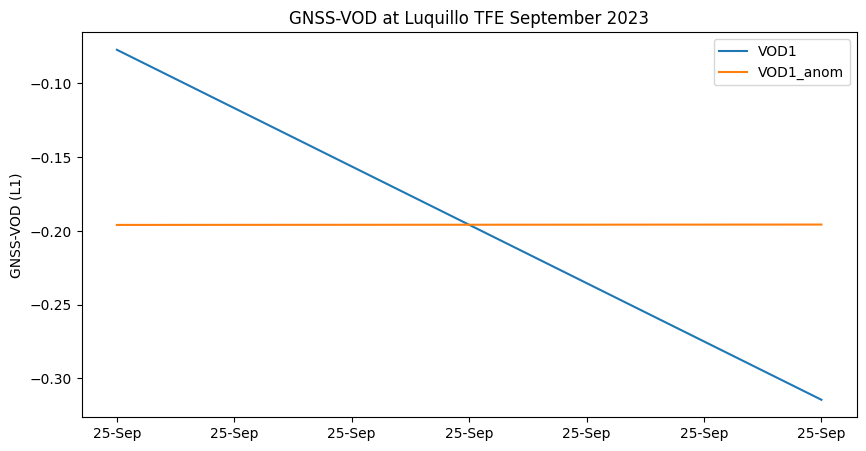

In [19]:
vod_names = ['VOD1','VOD1_anom']

fig, ax = plt.subplots(1,figsize=(10,5))
for i, iname in enumerate(vod_names): 
    # plot each measurement and color by signal to noise ratio
    hs = ax.plot(vod_ts.index.get_level_values('Epoch'),vod_ts[iname],label=iname)
    
myFmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('GNSS-VOD (L1)')
ax.legend()
plt.title('GNSS-VOD at Luquillo TFE September 2023')
#plt.savefig('figures/illustration_vod.png',facecolor='white', transparent=False,bbox_inches='tight')

We clearly see how subtracting the gridded hemispheric average before calculating the time series has substantially reduced the noise in our VOD time series. Here we see short spikes usually corresponding to rain events and water interception by the canopy. A very small diurnal cycle is somewhat visible on August 3 to 6, with dehydration during day and rehydration overnight.

### Longer time series

In principle, when calculating a time series over several months, the baseline should be regularly updated. One option could be to go for a "moving" baseline, with a window of a few weeks.

In the next release, there should be some functions to do exactly that with a batch logic (i.e. automatically).